# Input Driven Observations ("GLM-HMM")

Notebook prepared by Zoe Ashwood: feel free to email me with feedback or questions (zashwood at cs dot princeton dot edu).

This notebook demonstrates the "InputDrivenObservations" class, and illustrates its use in the context of modeling decision-making data as in Ashwood et al. (2020) ([Mice alternate between discrete strategies during perceptual
decision-making](https://www.biorxiv.org/content/10.1101/2020.10.19.346353v1.full.pdf)).

Compared to the model considered in the notebook ["2 Input Driven HMM"](https://github.com/lindermanlab/ssm/blob/master/notebooks/2%20Input%20Driven%20HMM.ipynb), Ashwood et al. (2020) assumes a stationary transition matrix where transition probabilities *do not* depend on external inputs. However, observation probabilities now *do* depend on external covariates according to:

$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{\sum_{c'=1}^C \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

where $c \in \{1, ..., C\}$ indicates the categorical class for the observation, $u_{t} \in \mathbb{R}^{M}$ is the set of input covariates, and $w_{kc} \in \mathbb{R}^{M}$ is the set of input weights associated with state $k$ and class $c$. These weights, along with the transition matrix and initial state probabilities, will be learned.

In Ashwood et al. (2020), $C = 2$ as $y_{t}$ represents the binary choice made by an animal during a 2AFC (2-Alternative Forced Choice) task. The above equation then reduces to:

$$
\begin{align}
\Pr(y_t = 1 \mid z_{t} = k, u_t, w_{k}) = 
\frac{1}
{1 + \exp\{-w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

and only a single set of weights is associated with each state.

## 1. Setup
The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import one_hot, find_permutation

%matplotlib inline

npr.seed(0)

## 2. Input Driven Observations
We create a HMM with input-driven observations and 'standard' (stationary) transitions with the following line:  
```python
        ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", observation_kwargs=dict(C=num_categories), transitions="standard")
```

As in Ashwood et al. (2020), we are going to model an animal's binary choice data during a decision-making task, so we will set `num_categories=2` because the animal only has two options available to it. We will also set `obs_dim = 1` because the dimensionality of the observation data is 1 (if we were also modeling, for example, the binned reaction time of the animal, we could set `obs_dim = 2`).  For the sake of simplicity, we will assume that an animal's choice in a particular state is only affected by the external stimulus associated with that particular trial, and its innate choice bias. Thus, we will set `input_dim = 2` and we will simulate input data that resembles sequences of stimuli in what follows.  In Ashwood et al. (2020), they found that many mice used 3 decision-making states when performing 2AFC tasks. We will, thus, set `num_states = 3`.

### 2a. Initialize GLM-HMM

In [2]:
# Set the parameters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

## Generate test data

In [3]:
def categorical(p):
    return (p.cumsum(-1) >= np.random.uniform(size=p.shape[:-1])[..., None]).argmax(-1)

In [4]:
zcurr = 0
scurr = 0

def next_state(zcurr):
    zlst = [0, 1, 2]
    if np.random.uniform() < 0.1: #switch
        zlst.pop(zcurr)
        return zlst[0] if np.random.uniform() > 0.5 else zlst[1]
    return zcurr

def next_target(scurr):
    return scurr if np.random.uniform() > 0.1 else 1 - scurr

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

zlst = [0]
ylst = [0]
slst = [0]
rlst = [0]
w = np.array([[5, 0], [0, 5], [0, -5]])
np.random.seed(0)
for i in range(1000):
    zcurr = next_state(zcurr)
    zlst.append(zcurr)
    
    scurr = next_target(scurr)
    slst.append(scurr)
    
    yprob = w[zcurr,0] * (int(ylst[i]) * 2 - 1) * (int(rlst[i]) * 2 - 1) + w[zcurr, 1]
    y = np.random.uniform() < sigmoid(yprob)
    ylst.append(y)
    
    rcurr = y == scurr
    rlst.append(rcurr)


In [28]:
inpts1 = (np.array(ylst, dtype='int') * 2 - 1) * (np.array(rlst, dtype='int') * 2 - 1)
inpts2 = np.ones(len(ylst))
inpts = np.array([inpts1, inpts2]).T
true_choices = np.array([ylst], dtype='int').T
inpts = inpts[:-1,:]
true_choices = true_choices[1:]
print('inpts shape:', inpts.shape, '. true choices shape:', true_choices.shape)

inpts shape: (1000, 2) . true choices shape: (1000, 1)


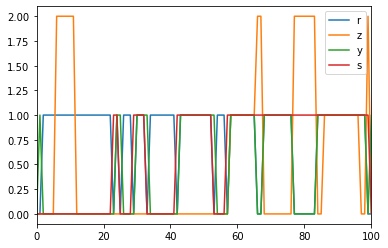

In [29]:
plt.plot(rlst,label='r')
plt.plot(zlst, label='z')
plt.plot(ylst, label='y')
plt.plot(slst, label='s')
plt.xlim(0, 100)
plt.legend()

## 3. Fit GLM-HMM and perform recovery analysis

### 3a. Maximum Likelihood Estimation

Now we instantiate a new GLM-HMM and check that we can recover the generative parameters in simulated data:

In [30]:
new_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = new_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

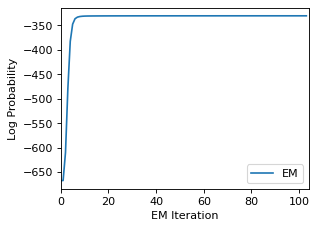

In [31]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
#plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

### 3b. Retrieved parameters

Compare retrieved weights and transition matrices to generative parameters. To do this, we may first need to permute the states of the fit GLM-HMM relative to the
generative model.  One way to do this uses the `find_permutation` function from `ssm`:

In [9]:
new_glmhmm.permute(find_permutation(true_latents[0], new_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

NameError: name 'true_latents' is not defined

Now plot generative and retrieved weights for GLMs (analogous plot to Figure S1c in 
Ashwood et al. (2020)):

In [ ]:
new_glmhmm.ob

Text(0.5, 1.0, 'Weight recovery')

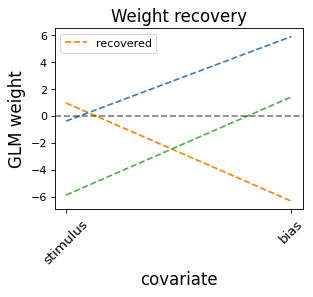

In [32]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0:
#         plt.plot(range(input_dim), gen_weights[k][0], marker='o',
#                  color=cols[k], linestyle='-',
#                  lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "recovered", linestyle = '--')
    else:
#         plt.plot(range(input_dim), gen_weights[k][0], marker='o',
#                  color=cols[k], linestyle='-',
#                  lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle = '--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery", fontsize=15)

Now plot generative and retrieved transition matrices (analogous plot to Figure S1c in 
Ashwood et al. (2020)):

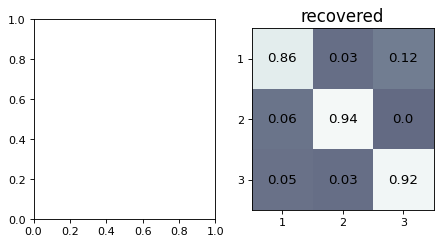

In [33]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
# gen_trans_mat = np.exp(gen_log_trans_mat)[0]
# plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
# for i in range(gen_trans_mat.shape[0]):
#     for j in range(gen_trans_mat.shape[1]):
#         text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
#                         color="k", fontsize=12)
# plt.xlim(-0.5, num_states - 0.5)
# plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
# plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
# plt.ylim(num_states - 0.5, -0.5)
# plt.ylabel("state t", fontsize = 15)
# plt.xlabel("state t+1", fontsize = 15)
# plt.title("generative", fontsize = 15)


plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


### 3c. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [34]:
# Get expected states:
posterior_probs = [new_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip([true_choices], [inpts])]

(0.0, 100.0)

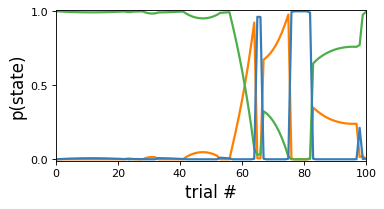

In [35]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)
plt.xlim(0, 100)

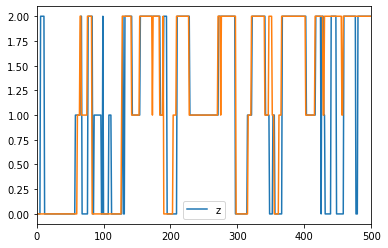

In [60]:
decoded_states = np.argmax(posterior_probs[0], axis=1)
copy_states = decoded_states.copy()
copy_states[decoded_states == 1] = 0
copy_states[decoded_states == 0] = 1


# plt.plot(rlst,label='r')
plt.plot(zlst, label='z')
plt.plot(copy_states)
# plt.plot(ylst, label='y')
# plt.plot(slst, label='s')
plt.xlim(0, 500)
plt.legend()

In [68]:
np.sum(np.array(copy_states, dtype='int') == np.array(zlst, dtype='int'))

<ipython-input-68-1bd8fa2af5f7>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.sum(np.array(copy_states, dtype='int') == np.array(zlst, dtype='int'))


0

In [74]:
np.array(zlst) == np.array(copy_states)

<ipython-input-74-98e8faa0aabf>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.array(zlst) == np.array(copy_states)


False

In [92]:
x1 = np.array(zlst)[1:]
x2 = np.array(copy_states)
np.sum(x1==x2)

853

In [90]:
x1.shape

(1000,)

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [26]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

Text(0, 0.5, 'frac. occupancy')

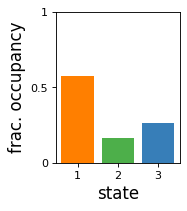

In [27]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    plt.bar(z, occ, width = 0.8, color = cols[z])
plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('state', fontsize = 15)
plt.ylabel('frac. occupancy', fontsize=15)

## 4. Fit GLM-HMM and perform recovery analysis: Maximum A Priori Estimation

Above, we performed Maximum Likelihood Estimation to retrieve the generative parameters of the GLM-HMM in simulated data. In the small data regime, where we do not have many trials available to us, we may instead want to perform Maximum A Priori (MAP) Estimation in order to incorporate a prior term and restrict the range for the best fitting parameters. Unfortunately, what is meant by 'small data regime' is problem dependent and will be affected by the number of states in the generative GLM-HMM, and the specific parameters of the generative model, amongst other things. In practice, we may perform both Maximum Likelihood Estimation and MAP estimation and compare the ability of the fit models to make predictions on held-out data (see Section 5 on Cross-Validation below).  

The prior we consider for the GLM-HMM is the product of a Gaussian prior on the GLM weights, $W$, and a Dirichlet prior on the transition matrix, $A$:

$$
\begin{align}
\Pr(W, A) &= \mathcal{N}(W|0, \Sigma) \Pr(A|\alpha) \\&= \mathcal{N}(W|0, diag(\sigma^{2}, \cdots, \sigma^{2})) \prod_{j=1}^{K} \dfrac{1}{B(\alpha)} \prod_{k=1}^{K} A_{jk}^{\alpha -1}
\end{align}
$$

There are two hyperparameters controlling the strength of the prior: $\sigma$ and $\alpha$.  The larger the value of $\sigma$ and if $\alpha = 1$, the more similar MAP estimation will become to Maximum Likelihood Estimation, and the prior term will become an additive offset to the objective function of the GLM-HMM that is independent of the values of $W$ and $A$.  In comparison, setting $\sigma = 2$ and $\alpha = 2$ will result in the prior no longer being independent of $W$ and $\alpha$.  

In order to perform MAP estimation for the GLM-HMM with `ssm`, the new syntax is:

```python
ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))```

where `prior_sigma` is the $\sigma$ parameter from above, and `prior_alpha` is the $\alpha$ parameter.

In [17]:
# Instantiate GLM-HMM and set prior hyperparameters
prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

In [18]:
# Fit GLM-HMM with MAP estimation:
_ = map_glmhmm.fit(true_choices, inputs=inpts, method="em", num_iters=N_iters, tolerance=10**-4)

Compare final likelihood of data with MAP estimation and MLE to likelihood under generative model (note: we cannot use log_probability that is output of `fit` function as this incorporates prior term, which is not comparable between generative and MAP models). We want to check that MAP and MLE likelihood values are higher than true likelihood; if they are not, this may indicate a poor initialization and that we should refit these models.

In [19]:
true_likelihood = true_glmhmm.log_likelihood(true_choices, inputs=inpts)
mle_final_ll = new_glmhmm.log_likelihood(true_choices, inputs=inpts) 
map_final_ll = map_glmhmm.log_likelihood(true_choices, inputs=inpts) 

Text(0, 0.5, 'loglikelihood')

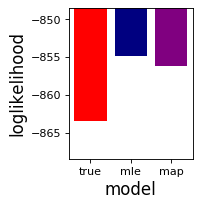

In [20]:
# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [true_likelihood, mle_final_ll, map_final_ll]
colors = ['Red', 'Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((true_likelihood-5, true_likelihood+15))
plt.xticks([0, 1, 2], ['true', 'mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

## 5. Cross Validation

To assess which model is better - the model fit via Maximum Likelihood Estimation, or the model fit via MAP estimation - we can investigate the predictive power of these fit models on held-out test data sets.

In [21]:
# Create additional input sequences to be used as held-out test data
num_test_sess = 10
test_inpts = np.ones((num_test_sess, num_trials_per_sess, input_dim)) 
test_inpts[:,:,0] = np.random.choice(stim_vals, (num_test_sess, num_trials_per_sess)) 
test_inpts = list(test_inpts)

In [22]:
# Create set of test latents and choices to accompany input sequences:
test_latents, test_choices = [], []
for sess in range(num_test_sess):
    test_z, test_y = true_glmhmm.sample(num_trials_per_sess, input=test_inpts[sess])
    test_latents.append(test_z)
    test_choices.append(test_y)

In [23]:
# Compare likelihood of test_choices for model fit with MLE and MAP:
mle_test_ll = new_glmhmm.log_likelihood(test_choices, inputs=test_inpts) 
map_test_ll = map_glmhmm.log_likelihood(test_choices, inputs=test_inpts) 

Text(0, 0.5, 'loglikelihood')

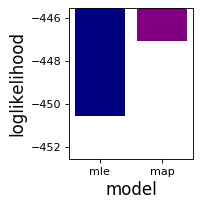

In [24]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_test_ll, map_test_ll]
colors = ['Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors[z])
plt.ylim((mle_test_ll-2, mle_test_ll+5))
plt.xticks([0, 1], ['mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

Here we see that the model fit with MAP estimation achieves higher likelihood on the held-out dataset than the model fit with MLE, so we would choose this model as the best model of animal decision-making behavior (although we'd probably want to perform multiple fold cross-validation to be sure that this is the case in all instantiations of test data).   

Let's finish by comparing the retrieved weights and transition matrices from MAP estimation to the generative parameters.

In [25]:
map_glmhmm.permute(find_permutation(true_latents[0], map_glmhmm.most_likely_states(true_choices[0], input=inpts[0])))

Text(0.5, 1.0, 'MAP')

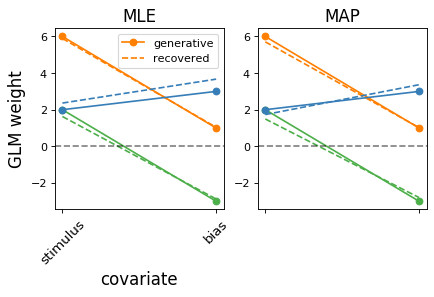

In [26]:
fig = plt.figure(figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
plt.subplot(1,2,1)
recovered_weights = new_glmhmm.observations.params
for k in range(num_states):
    if k ==0: # show labels only for first state
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k],
                 lw=1.5, label="generative")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = 'recovered', linestyle='--')   
    else:
        plt.plot(range(input_dim), gen_weights[k][0], marker='o',
                 color=cols[k], 
                 lw=1.5, label="")
        plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MLE", fontsize = 15)
plt.legend()

plt.subplot(1,2,2)
recovered_weights = map_glmhmm.observations.params
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k],
             lw=1.5, label="", linestyle = '-')
    plt.plot(range(input_dim), recovered_weights[k][0], color=cols[k],
                 lw=1.5,  label = '', linestyle='--')
plt.yticks(fontsize=10)
plt.xticks([0, 1], ['', ''], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.title("MAP", fontsize = 15)

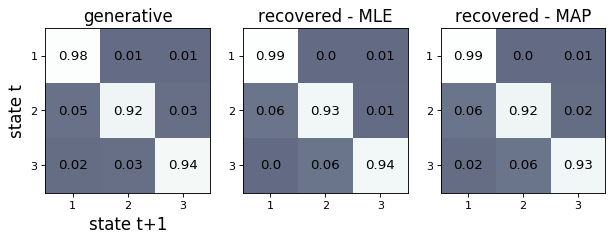

In [27]:
fig = plt.figure(figsize=(7, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("generative", fontsize = 15)


plt.subplot(1, 3, 2)
recovered_trans_mat = np.exp(new_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MLE", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)


plt.subplot(1, 3, 3)
recovered_trans_mat = np.exp(map_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered - MAP", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)